In [1]:
import jax
import jax.numpy as jnp
import sys
sys.path.append('..')
import networks
from utils import *
from networks import *

In [2]:
import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap_pred = cmr.get_sub_cmap('cmr.swamp', 0.1, 1)
cmap_error = cmr.get_sub_cmap('cmr.freeze', 0.1, 1)

In [3]:
problem = "kdv"
running_on = "local"
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
else:
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"

In [4]:
data = jnp.load(data_path + problem + ".npz")
train_val_test = train_val_test_split(data["data"], 0.8, 0.1, 0.1)
scaled_data = jnp.load(data_path + problem + "_z_score.npz")

In [5]:
u_standardizer = GaussianStandardizer(train_val_test["train"])
x_standardizer = GaussianStandardizer(data["x"])
t_standardizer = GaussianStandardizer(data["t"])

In [6]:
a_train_s = scaled_data["a_train_s"]
u_train_s = scaled_data["u_train_s"]
a_val_s = scaled_data["a_val_s"]
u_val_s = scaled_data["u_val_s"]
a_test_s = scaled_data["a_test_s"]
u_test_s = scaled_data["u_test_s"]

x_train_s = scaled_data["x_train_s"]
t_train_s = scaled_data["t_train_s"]

x_test_s = scaled_data["x_test_s"] 
t_test_s = scaled_data["t_test_s"]

x_test = x_standardizer.decode(x_test_s)
t_test = t_standardizer.decode(t_test_s)

u_test = u_standardizer.decode(u_test_s)

In [7]:
pretty_names = {
    "deeponet": "DeepONet",
    "modified_deeponet": "ModifiedDeepONet",
    "fno_timestepping": "FNOTimeStepping",
    "fno1d": "FNO1d",
    "fno2d": "FNO2d"
}

networks = {
    "deeponet": DeepONet,
    "modified_deeponet": ModifiedDeepONet,
    "fno_timestepping": FNOTimeStepping,
    "fno1d": FNO1d,
    "fno2d": FNO2d
}

In [8]:
models = {}
trainers = {}

for network_name, network in networks.items():
    trainers[network_name] = Trainer.from_checkpoint(checkpoint_path + f"{network_name}_{problem}", 
                                                network)
    models[network_name] = trainers[network_name].model

In [10]:
from traditional_solvers import Dx

### Plot one prediction from the test set for t = 0, t $\approx$ 1, t $\approx$ 2, t $\approx$ 3

In [50]:
sample_idx = 88

u_preds = {}
u_t_preds = {}
u_x_preds = {}
u_preds_FD_t = {}
u_preds_FD_x = {}
for network_name, model in models.items():
    """
    To extrapolate, we use the solution at t~2 as the initial condition for the next time interval [~2, 4).
    """
    t = t_test_s[t_test < 2] # time interval [0, 2)
    # prediction on [0, 2)
    u_pred1_s = model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t)
    u_t_pred1 = model.u_t_whole_grid(a_test_s[sample_idx], x_test_s, t)
    u_x_pred1 = model.u_x_whole_grid(a_test_s[sample_idx], x_test_s, t)
    # prediction on [~2, 4) by using the last prediction (at t~2) as initial condition
    u_pred2_s = model.predict_whole_grid(u_pred1_s[-1], x_test_s, t)
    u_t_pred2 = model.u_t_whole_grid(u_pred1_s[-1], x_test_s, t)
    u_x_pred2 = model.u_x_whole_grid(u_pred1_s[-1], x_test_s, t)
    
    # concatenate the predictions on [0, 2) and [~2, 4), making sure not to include the overlapping time point twice
    u_preds[network_name] = model.decode_u(jnp.concatenate((u_pred1_s, u_pred2_s[1:]), axis=0))[:len(t_test)]
    u_t_preds[network_name] = (jnp.concatenate((u_t_pred1, u_t_pred2[1:]), axis=0))[:len(t_test)]
    u_x_preds[network_name] = (jnp.concatenate((u_x_pred1, u_x_pred2[1:]), axis=0))[:len(t_test)]
    
    # finite difference of the predictions
    u_preds_FD_x[network_name] = Dx(u_preds[network_name], x_test[1], axis = 1)
    u_preds_FD_t[network_name] = Dx(u_preds[network_name], t_test[1], axis = 0)

In [51]:
u_gt = u_test[sample_idx]
u_t_FD = Dx(u_gt, t_test[1], axis = 0)
u_x_FD = Dx(u_gt, x_test[1], axis = 1)

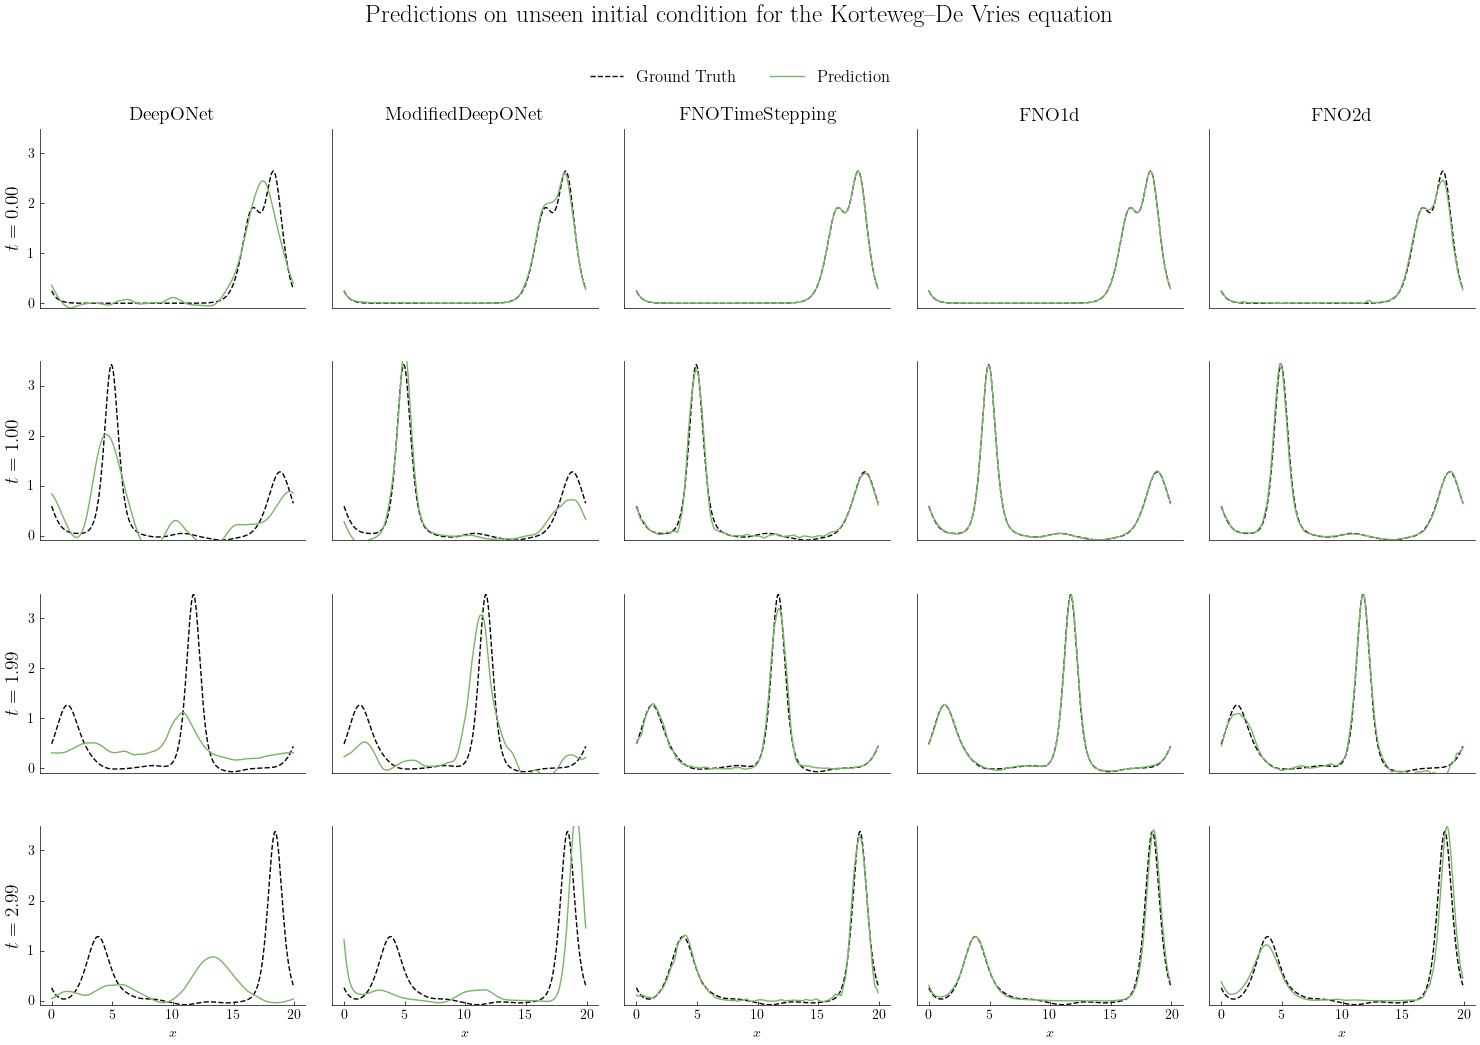

In [13]:
pred_color = "#7ab368"

time_indices = [0, jnp.where(t_test == 1)[0][0], jnp.where(t_test < 2)[0][-1], -1]
time_labels = [rf'$t={t_test[time_indices[0]]:.2f}$', rf'$t={t_test[time_indices[1]]:.2f}$', rf'$t={t_test[time_indices[2]]:.2f}$', rf'$t={t_test[time_indices[3]]:.2f}$']

fig, axes = plt.subplots(len(time_indices), len(u_preds), figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for i, time_idx in enumerate(time_indices):
    for j, (model_name, u_pred) in enumerate(u_preds.items()):
        ax = axes[i, j]
        ax.plot(x_test, u_gt[time_idx, :], 'k--', label='Ground Truth')
        ax.plot(x_test, u_pred[time_idx, :], color=pred_color, label='Prediction')
        ax.set_ylim(y_min, y_max)  # Set the y-axis limits
        
        ax.tick_params(top=False,
                left=False,
                right=False, 
                bottom=False, 
                labelleft=False, 
                labelbottom=False, 
                which='both')
                
        if i == 0:
            ax.set_title(pretty_names[model_name], fontsize=14)
        if j == 0:
            ax.set_ylabel(time_labels[i], fontsize=14)
            ax.tick_params(left=True, labelleft=True)
        if i == len(time_indices) - 1:
            ax.set_xlabel(r'$x$')
            ax.tick_params(bottom=True, labelbottom=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Predictions on unseen initial condition for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("predictions/pred_kdv.svg")
plt.show()

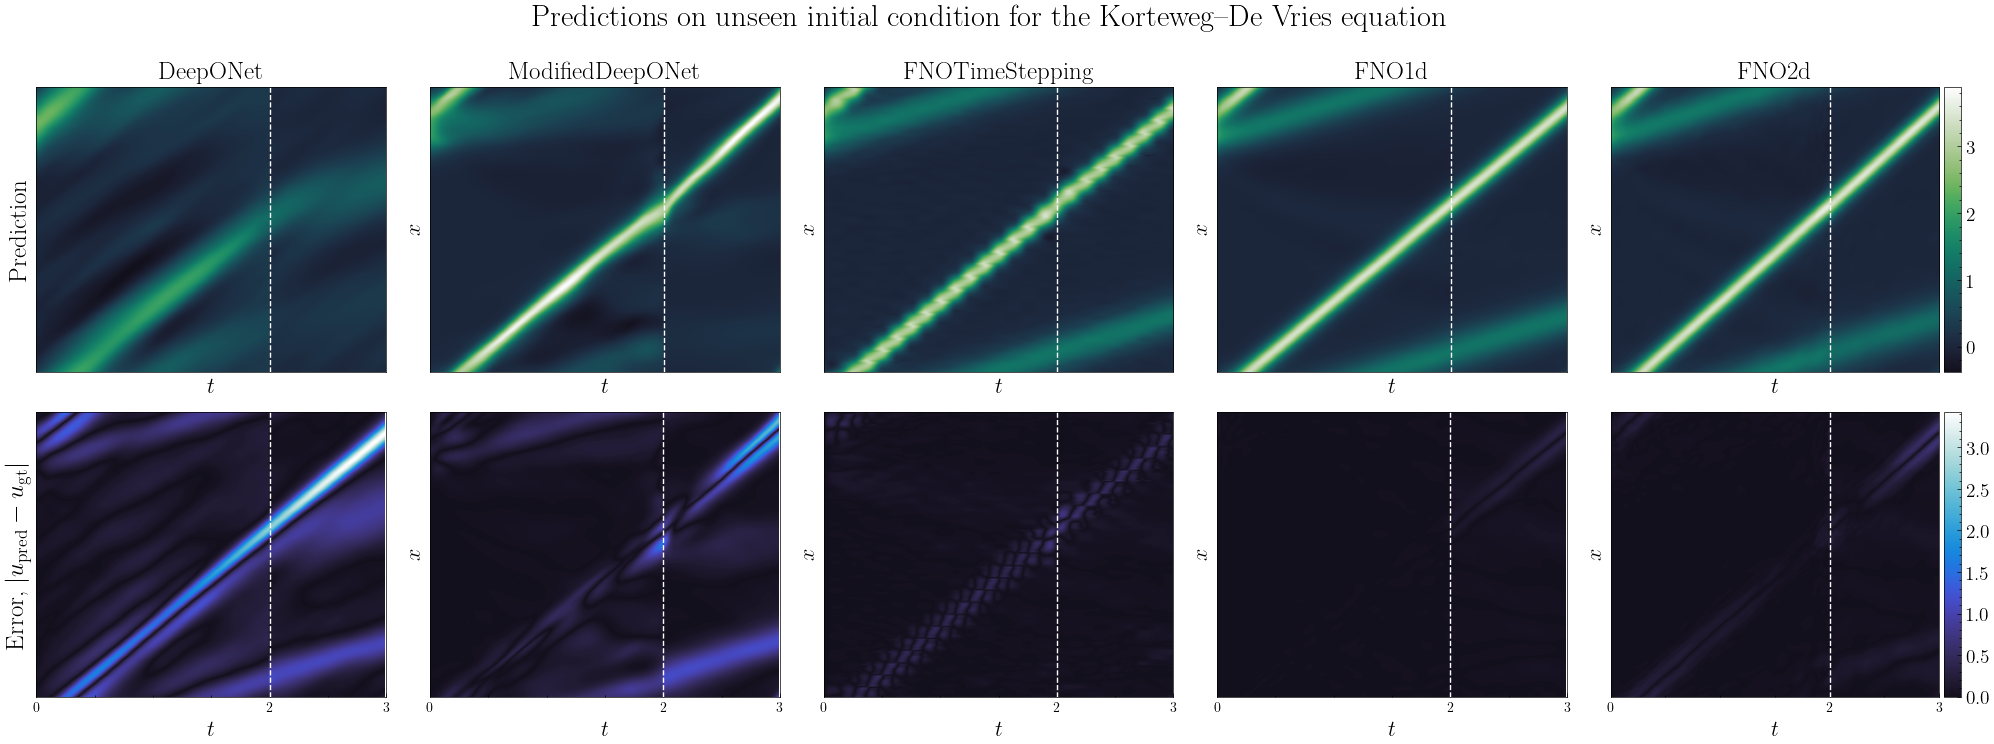

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(2, len(u_preds), figsize=(20, 7.5))

vmin_pred, vmax_pred = min(u_pred.min() for u_pred in u_preds.values()), max(u_pred.max() for u_pred in u_preds.values())
vmin_error, vmax_error = 0, max(jnp.abs(u_pred - u_gt).max() for u_pred in u_preds.values())

for i, (model_name, u_pred) in enumerate(u_preds.items()):
    # First row: imshow of u_pred
    ax1 = axes[0, i]
    im1 = ax1.imshow(u_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin_pred, vmax=vmax_pred)
    ax1.set_title(pretty_names[model_name], fontsize=18)
    ax1.set_xlabel(r'$t$', fontsize=16)
    ax1.set_ylabel(r'$x$', fontsize=16)
    ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
    ax1.tick_params(
                top=False,
                right=False, 
                bottom=False, 
                left=False,
                labelleft=False, 
                labelbottom=False, 
                which='both')
    
    # Second row: imshow of u_pred - u_gt
    ax2 = axes[1, i]
    im2 = ax2.imshow(jnp.abs(u_pred - u_gt).T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin_error, vmax=vmax_error)
    ax2.set_xlabel(r'$t$', fontsize=16)
    ax2.set_ylabel(r'$x$', fontsize=16)
    ax2.axvline(x=2, color='white', linestyle='--')
    ax2.set_xticks([0, 2, 3]) 
    ax2.tick_params(
            top=False,
            right=False, 
            #bottom=False, 
            left=False,
            labelleft=False, 
            #labelbottom=False, 
            which='both')

# Create a single colorbar for the first row
divider1 = make_axes_locatable(axes[0, -1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.ax.tick_params(labelsize=14)

# Create a single colorbar for the second row
divider2 = make_axes_locatable(axes[1, -1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.ax.tick_params(labelsize=14)

axes[0, 0].set_ylabel('Prediction', fontsize=18)
axes[1, 0].set_ylabel(r'Error, $|u_{\text{pred}} - u_{\text{gt}}|$', fontsize=18)

fig.suptitle('Predictions on unseen initial condition for the Korteweg–De Vries equation', fontsize=22, x=0.5, y=1)

plt.tight_layout()
plt.savefig("predictions/pred_kdv_imshow.svg")
plt.show()

# Spatial derivatives

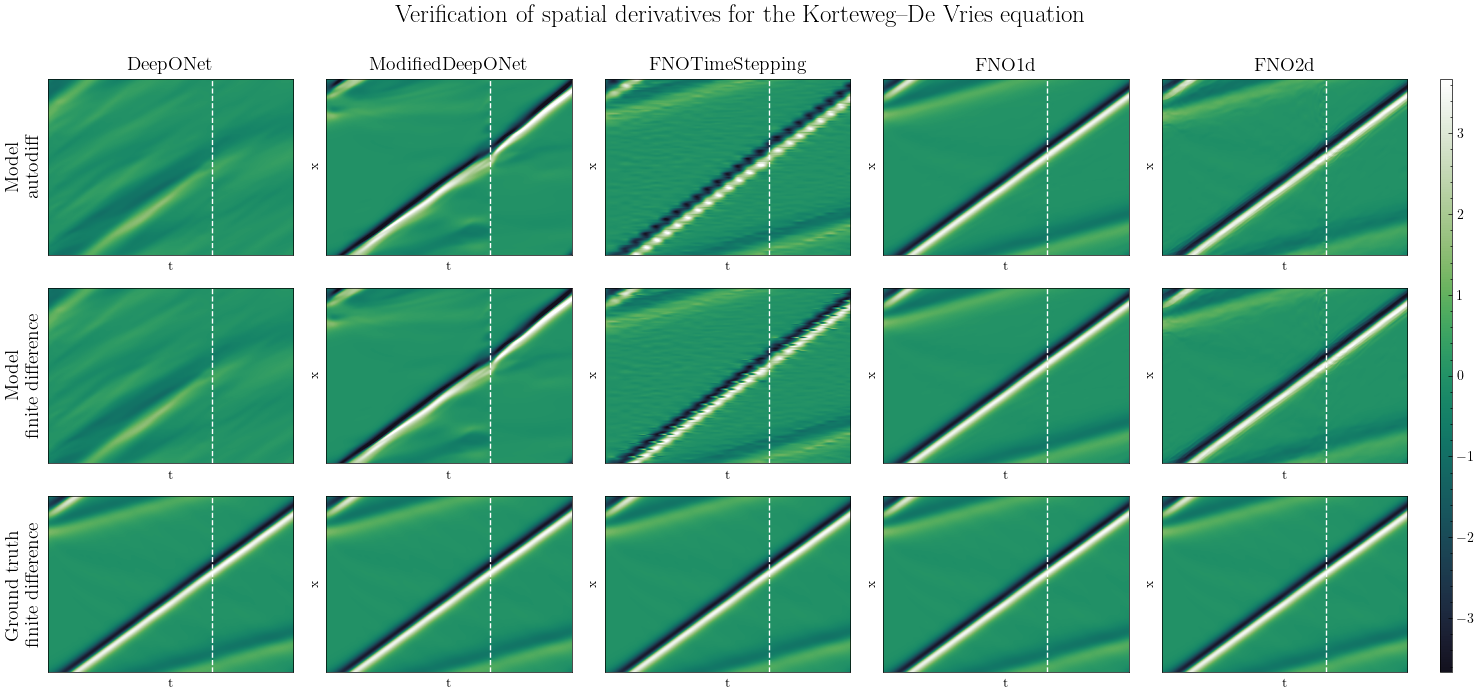

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 7))
gs = GridSpec(3, len(u_x_preds) + 1, width_ratios=[1] * len(u_x_preds) + [0.05])

vmin, vmax = u_x_FD.min(), u_x_FD.max()

axes = []
for i, (model_name, u_x_pred) in enumerate(u_x_preds.items()):
        # First row: imshow of u_x_pred
        ax1 = fig.add_subplot(gs[0, i])
        im1 = ax1.imshow(u_x_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin, vmax=vmax)
        ax1.set_title(pretty_names[model_name], fontsize=14)
        ax1.set_xlabel('t')
        ax1.set_ylabel('x')
        ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
        ax1.tick_params(
                        top=False,
                        right=False, 
                        bottom=False, 
                        left=False,
                        labelleft=False, 
                        labelbottom=False, 
                        which='both')
        axes.append(ax1)

        # Second row: imshow of u_preds_FD_x
        ax2 = fig.add_subplot(gs[1, i])
        im2 = ax2.imshow(u_preds_FD_x[model_name].T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin, vmax=vmax)
        ax2.set_xlabel('t')
        ax2.set_ylabel('x')
        ax2.axvline(x=2, color='white', linestyle='--')
        ax2.tick_params(
                        top=False,
                        right=False, 
                        bottom=False, 
                        left=False,
                        labelleft=False, 
                        labelbottom=False, 
                        which='both')
        axes.append(ax2)

        # Third row: imshow of u_x_FD
        ax3 = fig.add_subplot(gs[2, i])
        im3 = ax3.imshow(u_x_FD.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin, vmax=vmax)
        ax3.set_xlabel('t')
        ax3.set_ylabel('x')
        ax3.axvline(x=2, color='white', linestyle='--')
        ax3.tick_params(
                        top=False,
                        right=False, 
                        bottom=False, 
                        left=False,
                        labelleft=False, 
                        labelbottom=False, 
                        which='both')
        axes.append(ax3)

# Create a single colorbar for all rows
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im3, cax=cax)

axes[0].set_ylabel('Model\nautodiff', fontsize=14)
axes[1].set_ylabel('Model\nfinite difference', fontsize=14)
axes[2].set_ylabel('Ground truth\nfinite difference', fontsize=14)

fig.suptitle('Verification of spatial derivatives for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1)

plt.tight_layout()
plt.savefig("other/spatial_derivatives_kdv.svg")
plt.show()

# Time derivatives

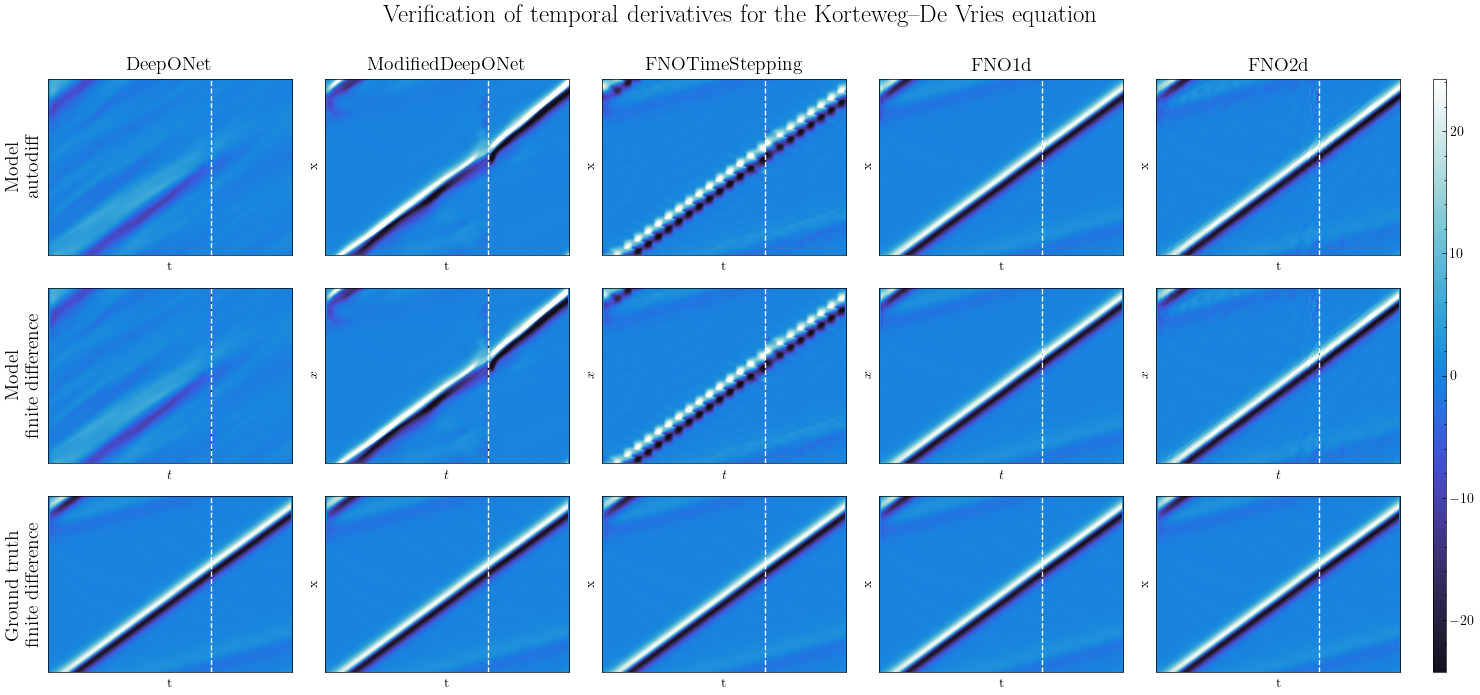

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 7))
gs = GridSpec(3, len(u_t_preds) + 1, width_ratios=[1] * len(u_t_preds) + [0.05])

u_t_FD = u_t_FD.at[:3].set(0).at[-3:].set(0)
vmin, vmax = u_t_FD.min(), u_t_FD.max()

axes = []
for i, (model_name, u_t_pred) in enumerate(u_t_preds.items()):
        # Fill exclude_range with np.nan
        u_preds_FD_t[model_name] = u_preds_FD_t[model_name].at[:3].set(0).at[-3:].set(0)
        
        # First row: imshow of u_pred
        ax1 = fig.add_subplot(gs[0, i])
        im1 = ax1.imshow(u_t_pred.T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin, vmax=vmax)
        ax1.set_title(pretty_names[model_name], fontsize=14)
        ax1.set_xlabel('t')
        ax1.set_ylabel('x')
        ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
        ax1.tick_params(
                                                        top=False,
                                                        right=False, 
                                                        bottom=False, 
                                                        left=False,
                                                        labelleft=False, 
                                                        labelbottom=False, 
                                                        which='both')
        axes.append(ax1)
        
        # Second row: finite difference of u_t
        ax2 = fig.add_subplot(gs[1, i])
        im2 = ax2.imshow(u_preds_FD_t[model_name].T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin, vmax=vmax)
        ax2.set_xlabel(r'$t$')
        ax2.set_ylabel(r'$x$')
        ax2.axvline(x=2, color='white', linestyle='--')
        ax2.tick_params(
                                        top=False,
                                        right=False, 
                                        bottom=False, 
                                        left=False,
                                        labelleft=False, 
                                        labelbottom=False, 
                                        which='both')
        axes.append(ax2)
        
        # Third row: imshow of u_t_FD
        ax3 = fig.add_subplot(gs[2, i])
        im3 = ax3.imshow(u_t_FD.T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower', vmin=vmin, vmax=vmax)
        ax3.set_xlabel('t')
        ax3.set_ylabel('x')
        ax3.axvline(x=2, color='white', linestyle='--')
        ax3.tick_params(
                                        top=False,
                                        right=False, 
                                        bottom=False, 
                                        left=False,
                                        labelleft=False, 
                                        labelbottom=False, 
                                        which='both')
        axes.append(ax3)

# Create a single colorbar for all rows
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im3, cax=cax)

axes[0].set_ylabel('Model\nautodiff', fontsize=14)
axes[1].set_ylabel('Model\nfinite difference', fontsize=14)
axes[2].set_ylabel('Ground truth\nfinite difference', fontsize=14)

fig.suptitle('Verification of temporal derivatives for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1)

plt.tight_layout()
plt.savefig("other/temporal_derivatives_kdv.svg")
plt.show()

# Loss plot

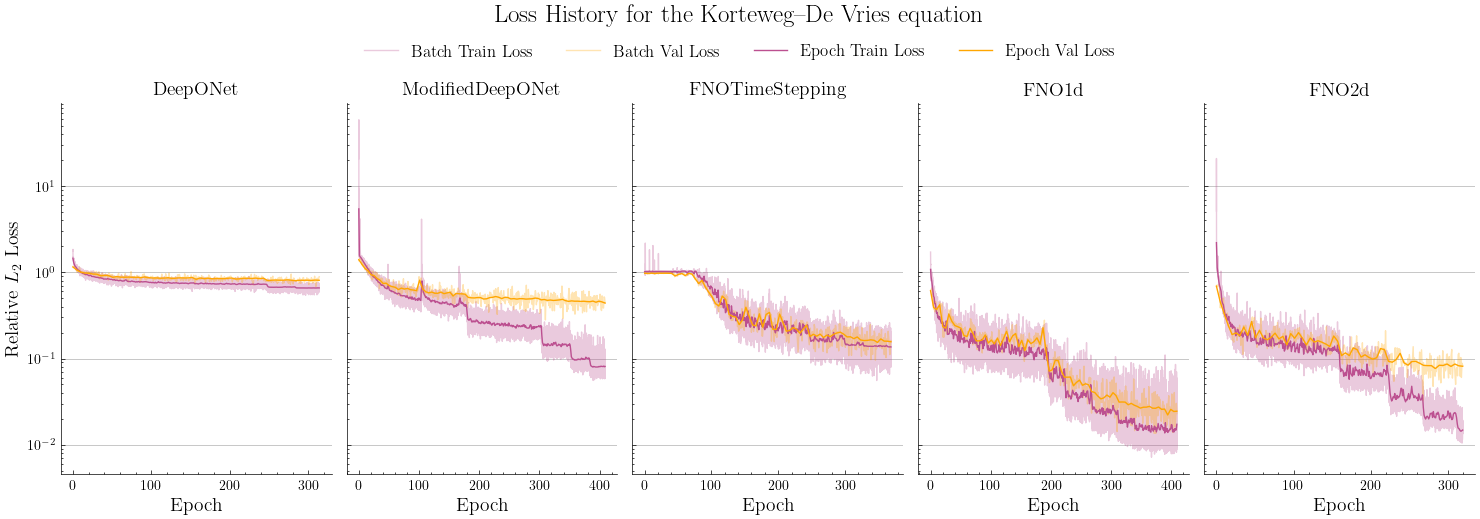

In [48]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
methods = list(trainers.keys())
train_color = '#bc5090'
val_color = '#ffa600'

for i, (model_name, trainer) in enumerate(trainers.items()):
        ax = axes[i]
        
        # Plot batch loss
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history_batch)),
                trainer.train_loss_history_batch, color=train_color, alpha=0.3, label='Batch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history_batch)),
                trainer.val_loss_history_batch, color=val_color, alpha=0.3, label='Batch Val Loss')
        
        # Plot epoch loss
        ax.plot(jnp.arange(len(trainer.train_loss_history)), trainer.train_loss_history, 
                color=train_color, label='Epoch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history)), 
                trainer.val_loss_history, 
                color=val_color, label='Epoch Val Loss')
        
        ax.set_title(pretty_names[model_name], fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(
                top=False,
                right=False, 
                which='both')
        ax.grid(True, which='major', axis='y', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
axes[0].set_ylabel(r'Relative $L_2$ Loss', fontsize=14)   

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.), fontsize='large')

fig.suptitle('Loss History for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1.05)
plt.tight_layout()
plt.savefig("loss/loss_kdv.svg")
plt.show()

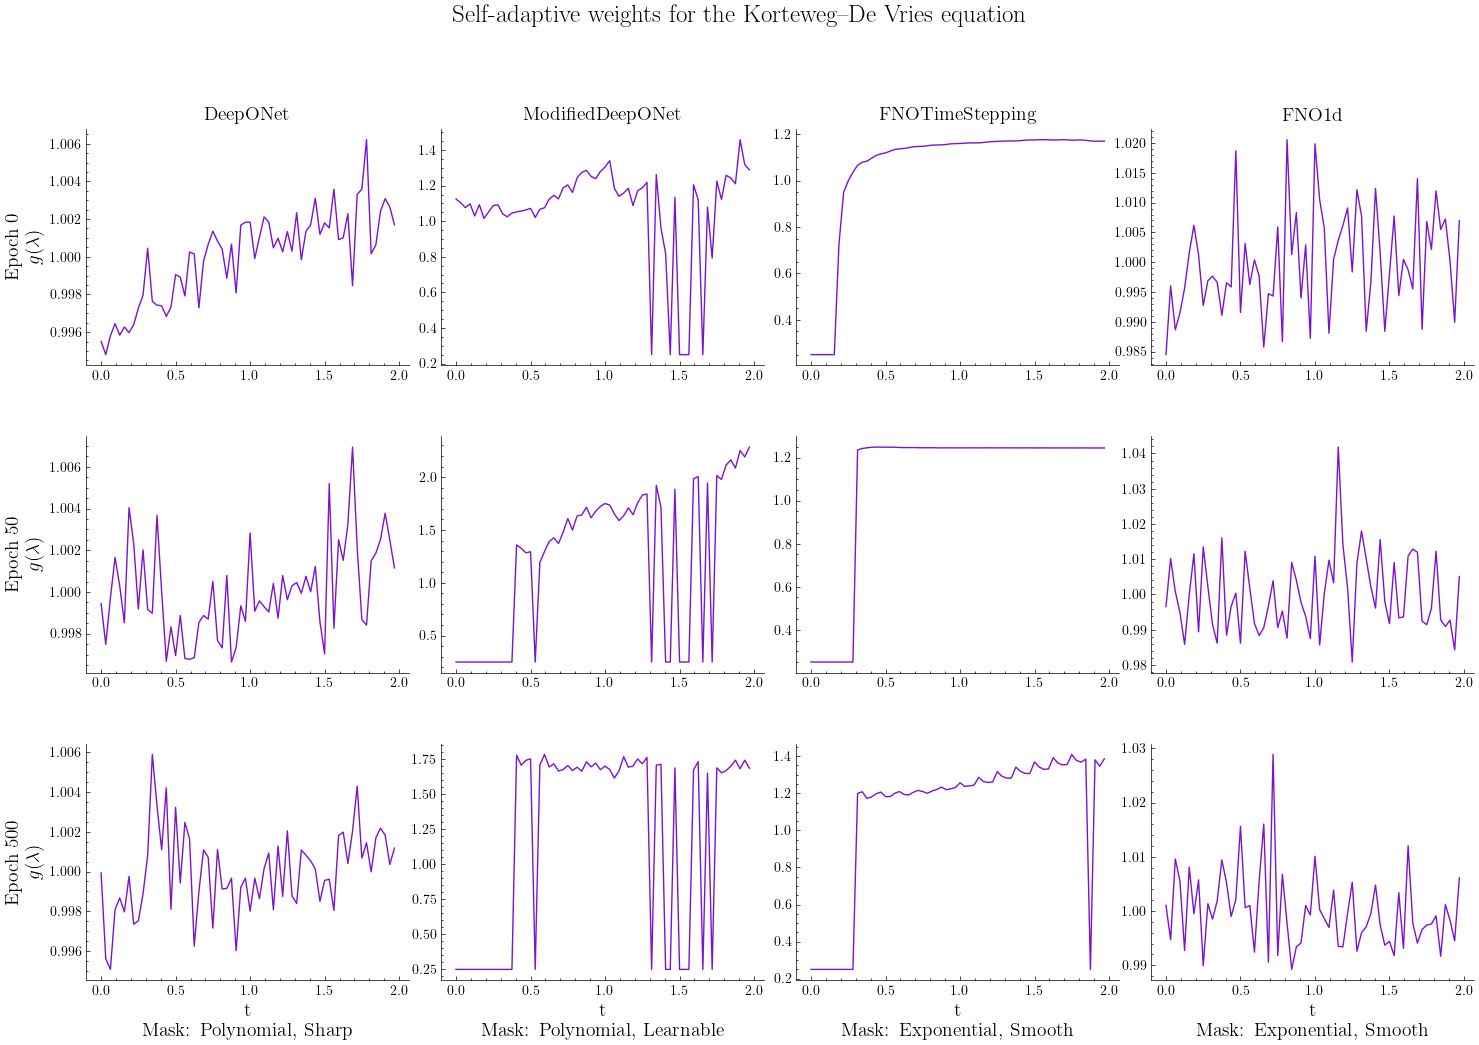

In [37]:
color = "#7d13cf"

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for j, (model_name, trainer) in enumerate(trainers.items()):
    if model_name != "fno2d":
        epochs = trainer.epochs_trained // 5
        λ_history = trainers[model_name].λ_history
        epoch_indices = [0, 10, 100]
        epoch_labels = [f'Epoch {epoch_indices[0]}\n'+r'$g(\lambda)$', f'Epoch {epoch_indices[1] * 5}\n'+r'$g(\lambda)$', f'Epoch {epoch_indices[2] * 5}\n'+r'$g(\lambda)$']
        for i, epoch_idx in enumerate(epoch_indices):
            ax = axes[i, j]
            ax.plot(t_standardizer.decode(t_train_s), λ_history[epoch_idx, 0, :], color=color)
            if i == 0:
                ax.set_title(pretty_names[model_name], fontsize=14)
            if i == 2:
                mask = trainer.hparams["λ_mask"].capitalize()
                learnable = trainer.hparams["λ_learnable"]
                smooth_or_sharp = trainer.hparams["λ_smooth_or_sharp"]
                if smooth_or_sharp is None: smooth_or_sharp = "Smooth"
                smooth_or_sharp = smooth_or_sharp.capitalize()
                type = "Learnable" if learnable else smooth_or_sharp
                ax.set_xlabel('t\n'+f'Mask: {mask}, {type}', fontsize=14)
            if j == 0:
                ax.set_ylabel(epoch_labels[i], fontsize=14)
            ax.tick_params(top=False,
                           right=False,
                           which='both')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Self-adaptive weights for the Korteweg–De Vries equation', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("other/self_adaptive_kdv.svg")
plt.show()